# End of Day Reversal test

- We download SP500 historical costituents from https://github.com/hanshof/sp500_constituents/
- Using Polygon free API plan we can download 2 years of OHLC 30min data.

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import pickle
import os
import matplotlib.pyplot as plt
import time
plt.style.use("dark_background")
from polygon import RESTClient

## Downloading every ticker

### Getting costituents and dealing with renamed tickers

In [2]:
# Load the CSV directly from the GitHub raw URL
url = "https://raw.githubusercontent.com/hanshof/sp500_constituents/refs/heads/main/sp_500_historical_components.csv"
costituents_df = pd.read_csv(url)

costituents_df['date'] = pd.to_datetime(costituents_df['date'])
costituents_df = costituents_df[costituents_df['date'].dt.year >= 2023].reset_index(drop=True)

# Create a dictionary where each key is a ticker and each associated element will be a dataframe
all_tickers = sorted(set(','.join(costituents_df['tickers']).split(',')))

# Tickers that changed their name
ticker_name_changes = [ 
    ('ABC', 'COR'),
    ('FISV','FI'),
    ('FRC','FRCB'),
    ('PKI','RVTY'),
    ('RVTY (Previously PKI)','RVTI'),
    ('RE','EG'),
    ('SIVB','SIVBQ'),
    ('BF-B','BF.B'),
    ('BRK-B','BRK.B'),
]

for old_name, new_name in ticker_name_changes:
    if old_name in all_tickers:
        if new_name is not None:
            all_tickers[all_tickers.index(old_name)] = new_name
            # Also replace omn the dataframe
            costituents_df['tickers'] = (
                costituents_df['tickers'].str.split(',').apply(lambda items: ','.join(
                    new_name if s.strip() == old_name else s.strip() for s in items
                    )))
            print(f'{old_name} found and replaced with {new_name}.')
        else:
            all_tickers.remove(old_name)
            print(f'Delete ticker {old_name}.')
    else:
        print(f"Column '{old_name}' not found, skipping...")


ABC found and replaced with COR.
FISV found and replaced with FI.
FRC found and replaced with FRCB.
PKI found and replaced with RVTY.
RVTY (Previously PKI) found and replaced with RVTI.
RE found and replaced with EG.
SIVB found and replaced with SIVBQ.
BF-B found and replaced with BF.B.
BRK-B found and replaced with BRK.B.


### Downloading data and saving to a .pkl file

Here the data-download is not very straight-forward... the Polygon free plan allows only 5 calls per minute, so I implemented some workarounds in order to wait a minute after each call.

The problem is that you don't know when the Ploygon library will make a call. I found it's around every ~1000 iterations, so I tell the loop to wait 60 seconds after 5k iterations. This is not a rule of thumb, so I just made sure that the loop check if data is already stored before requesting it, so I can re-run it to catch missed data.

***I suggest to not even try this thing because with the free plan it'll take around 6 hours to download everything.***

In [3]:
today = pd.Timestamp.today().strftime("%Y-%m-%d")
two_years_ago = (pd.Timestamp.today() - pd.DateOffset(years=2) + - pd.DateOffset(days=7)).strftime("%Y-%m-%d")
FILENAME = "polygon_data.pkl"

'''
This function opens a .pkl file that should contain a dictionary of dataframe indexed by key (ticker string).
If the file is not found then we create the dictionary.
We append to the dictionary a dataframe given by input and a tikcer string.
We ovwerwrite the pickle file with the new dictionary.
'''
def add_df_to_pkl(ticker, df):

    if os.path.exists(FILENAME):
        with open(FILENAME, "rb") as f:
            all_dfs = pickle.load(f)
    else:
        all_dfs = {}  # or whatever default you prefer
    
    all_dfs[ticker] = df

    with open(FILENAME, "wb") as f:
        pickle.dump(all_dfs, f, protocol=pickle.HIGHEST_PROTOCOL)

    del all_dfs

'''
It opens a .pkl file (if it exist) and gets the list of all keys of that dictionary.
This is a list of already downloaded tickers.
'''
def get_downloaded_list():
    if os.path.exists(FILENAME):
        with open(FILENAME, "rb") as f:
            all_dfs = pickle.load(f)
        return list(all_dfs.keys())
    else:
        return []

def get_time():
    return pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")

client = RESTClient("ARaPwpvoMU74XA2r49CRpHfQuN_PI4TN")
already_downloaded = get_downloaded_list()
c = 0
# time.sleep(60)
with open("log.txt", "a") as f:
    f.write(f"\n🏁 [{get_time()}] DOWNLOAD STARTED "+'==='*10+'\n')
for ticker in all_tickers:
    # If we already have data for this ticker, then skip to the next one.
    if ticker in already_downloaded:
        with open("log.txt", "a") as f:
            f.write(f"🔄 [{get_time()}] {ticker} skipped, already downloaded.\n")
        continue
    
    aggs = []
    # We wrap around try / excpet so in case of error the code does not crash.
    try:
        for a in client.list_aggs(ticker,30,"minute",two_years_ago,today,adjusted="true",sort="asc",limit=50_000):
            aggs.append(a)
            c+= 1    
            if c >= 1_000*5:
                time.sleep(60)
                c = 0

        df = pd.DataFrame(aggs)
        if df is None or df.empty:
            with open("log.txt", "a") as f:
                f.write(f"🟡 [{get_time()}] {ticker} No data.\n")
                # Need to sleep because even if no-data, we still made multiple calls
                time.sleep(60)
        else:
            df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
            df["timestamp"] = df["timestamp"].dt.tz_localize('UTC').dt.tz_convert('US/Eastern')
            add_df_to_pkl(ticker, df)
            with open("log.txt", "a") as f:
                rows = f"{len(df):,}".replace(",", "'")
                f.write(f"✅ [{get_time()}] {ticker} ({rows} rows).\n")

    except Exception as e:
        with open("log.txt", "a") as f:
            f.write(f"🔴 [{get_time()}] {ticker} {e}\n")
        # In case of exception the code would immediately go to the next ticker.
        # If the exception is caused by API limit then we would skip more than 60 tickers
        # the time for the api limit to reset.
        # hence we wait 60 seconds, we missed a ticker but we can re-download it later.
        time.sleep(60)

### Check downloaded data

In [4]:
with open(FILENAME, "rb") as f:
    all_dfs = pickle.load(f)

with open("log.txt", "a") as f:
    f.write(f"\n\n🔎 [{get_time()}] DATA INSPECTION "+'==='*10+'\n')

for ticker, df in all_dfs.items():
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp').sort_index()
    
    size = len(df)
    rows = f"{len(df):,}".replace(",", "'")
    first_date = df.index[0].date().isoformat() # convert to string in format 'YYYY-MM-DD'
    last_date = df.index[-1].date().isoformat()

    warning = '🔴' if first_date not in ['2023-10-11','2023-10-12'] or last_date not in ['2025-10-09','2025-10-10'] else '➡️'

    with open("log.txt", "a") as f:
        f.write(f"{warning} [{get_time()}] {ticker}\n")
        f.write(f"\t{rows} rows.\n")
        f.write(f"\tStart: {first_date}\tEnd: {last_date}.\n")

## Backtest
### Calculating indicators

In [ ]:
with open(FILENAME, "rb") as f:
    all_dfs = pickle.load(f)

# Sort all_dfs alphabetically
all_dfs = dict(sorted(all_dfs.items()))

with open("log.txt", "a") as f:
    f.write(f"\n\n🔎 [{get_time()}] ROD3 & LH CALCULATIONS "+'==='*10+'\n')

for ticker, df in all_dfs.items():
    with open("log.txt", "a") as f:
        f.write(f"➡️ [{get_time()}] {ticker}\n")
    
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp').sort_index()
    
    # ----------------------------------- ROD3 ----------------------------------- #
    
    yesterday_close = df['close'].at_time('15:30').shift(1)
    close_minus_60 =  df['close'].at_time('14:30')
    if len(yesterday_close) != len(close_minus_60):
        with open("log.txt", "a") as f:
            # closed_before = len(yesterday_close) - len(close_minus_60)
            f.write(f"\t🔴 {len(yesterday_close)} prices of yesterday at 15:59 (market close).\n")
            f.write(f"\t🔴 {len(close_minus_60)} prices at 14:59.\n")
        
        # Store a list of all the dates where we have both yesterday close and price at 15:00
        common_dates = yesterday_close.index.normalize().intersection(close_minus_60.index.normalize())
        yesterday_close = yesterday_close[yesterday_close.index.normalize().isin(common_dates)]
        close_minus_60 = close_minus_60[close_minus_60.index.normalize().isin(common_dates)]
        
    df['ROD3'] = ( close_minus_60  / yesterday_close.values ) - 1
    
    # ------------------------------------ LH ------------------------------------ #
    
    close_minus_30 =  df['close'].at_time('15:00')
    today_close = df['close'].at_time('15:30')
    if len(close_minus_30) != len(today_close):
        with open("log.txt", "a") as f:
            f.write(f"\t🔴 {len(close_minus_30)} prices at 15:29.\n")
            f.write(f"\t🔴 {len(close_minus_60)} Prices at 15:59 (market close).\n")
        
        common_dates = today_close.index.normalize().intersection(close_minus_30.index.normalize())
        close_minus_30 = close_minus_30[close_minus_30.index.normalize().isin(common_dates)]
        today_close = today_close[today_close.index.normalize().isin(common_dates)]


    df['LH'] = ( today_close / close_minus_30.values ) - 1
    
    # -------------------------------- FINAL CHECK ------------------------------- #

    # We need to check that for every ROD3 at day X there is a LH at day X
    rod3 = df['ROD3'].dropna()
    lh = df['LH'].dropna()

    if len(rod3) != len(lh):
        with open("log.txt", "a") as f:
            f.write(f"\t🔴 {len(rod3)} ROD3 observations.\n")
            f.write(f"\t🔴 {len(lh)} LH observations.\n")

        common_dates = rod3.index.normalize().intersection(lh.index.normalize())
        df['ROD3'] = rod3[rod3.index.normalize().isin(common_dates)]
        df['LH'] = lh[lh.index.normalize().isin(common_dates)]

    all_dfs[ticker] = df
    

### Cross-sectional average

In [6]:
# Make a df that contains all ROD3 for every stock
rod3_df = pd.concat(
    {ticker: df['ROD3'].dropna() for ticker, df in all_dfs.items()},
    axis=1
).sort_index()

# Now calculate the average, so that we have the average ROD3 value of 
# the market for every day
rod3_market_avg = rod3_df.mean(axis=1)  

# Now get the mean of the market ROD3 over the time period of the data
rod3_market_avg_value = rod3_market_avg.mean()
print(rod3_market_avg_value)


lh_df = pd.concat(
    {ticker: df['LH'].dropna() for ticker, df in all_dfs.items()},
    axis=1
).sort_index()

lh_market_avg = lh_df.mean(axis=1)  

lh_market_avg_value = lh_market_avg.mean()
print(lh_market_avg_value)


0.0007344759421986631
0.00022177929735063236


### Doing the backtest

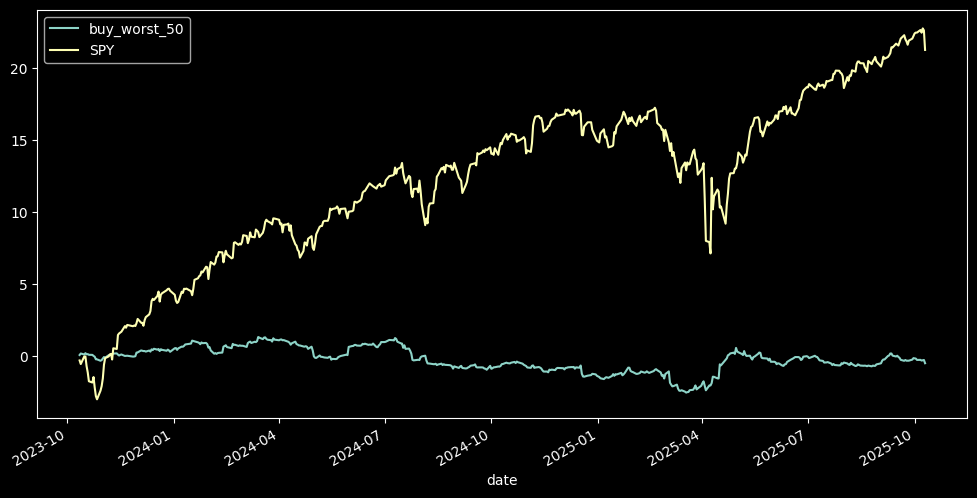

In [7]:
# This is a touple: (date, return)
closed_trades = []
PORTFOLIO_SIZE = 50
with open("log.txt", "a") as f:
    f.write(f"\n\n🧪 [{get_time()}] BACKTESTING "+'==='*50+'\n')

# Iterate trough every day of ROD3
for date, row in rod3_df.iterrows():
    # Take all tickers that are inside SP500 currently
    costituents_dates = pd.to_datetime(costituents_df['date'], format="%Y-%m-%d", errors="coerce")
    # Take yesterday date for costituents to avoid look-ahead bias
    current_date = pd.to_datetime(date.date()) - pd.Timedelta(days=1)
    # Take all dates in costituents dates lower or equal to current date
    mask = costituents_dates.le(current_date)
    if not mask.any():
        print('ERROR: No costituents for this date')
        break
    # Get the index for the nearest date
    idx = costituents_dates[mask].idxmax()  # latest date ≤ ts_date
    current_costituents = costituents_df.loc[idx]['tickers']
    current_costituents =  [x.strip() for x in current_costituents.split(",")]

    tradeable_tickers = row.loc[row.index.isin(current_costituents)]
    # Given the day, retrieve the top 10 under-performers
    # now we have a dataframe with 10 rows, index is given by tickers.
    worst = tradeable_tickers.dropna().nsmallest(PORTFOLIO_SIZE) # or .nlargest(10)
    
    # Now get all LH values realized for this day
    realized_lh = lh_df.loc[lh_df.index.date == date.date()]

    # skip days where market closed before
    if realized_lh.empty:
        print(f'ERROR: No LH observations for {date.date()}, could be due to anticipated market close')
        continue
    
    # Now we consider realized LH values for tickers we bought
    realized_returns = realized_lh[worst.index.values]
    if len(realized_returns) > 1:
        print('ERROR: this should not be happening.')
        break
    
    # Traspose and make it in a table of same format of ROD3 (i.e. index = tickers)
    realized_returns = realized_returns.T.squeeze('columns')

    '''
    Here it is assumed that each stock has the same invested capital.
    i.e. we assume that for every stock we buy a certain amount of shares 
    so that each position, at time of purchase, has the same exact monetary value.

    This is done just so that we can easily sum percentages, otherwise we would need 
    to weight everything by the purchasing price and purchased amount of shares.

    This makes for a utopically irrealistic equally weighted strategy.
    '''
    return_for_the_day = realized_returns.sum()    
    closed_trades.append((date, return_for_the_day))

    with open("log.txt", "a") as f:
        f.write(f'\n[{get_time()}]'+'-.-.-.-.-.'*50+'\n')
        f.write(f'🗓️ Backtesting {date.date()}\n\n')
        # Make a table with ROD3 and LH
        day_summary = pd.concat([worst.rename('ROD3'),realized_returns.rename('LH')],axis=1)
        
        f.write(day_summary.to_string()+'\n\n')
        f.write(f'Return: {day_summary['LH'].sum()*100:.2f}%\n')

# We turn closed trades into a dataframe
closed_trades = pd.DataFrame.from_records(closed_trades, columns=['date', f'buy_worst_{PORTFOLIO_SIZE}']).set_index('date')

# Download SP500 and calculate daily returns to do a comparison
start = closed_trades.index[0].date()
end = closed_trades.index[-1].date()
# yfinance dates is exclusive, so add one day to include end_inclusive
start = (pd.to_datetime(start) - pd.Timedelta(days=1)).strftime("%Y-%m-%d")
end = (pd.to_datetime(end) + pd.Timedelta(days=1)).strftime("%Y-%m-%d")
# Download daily prices
sp500_df = yf.Ticker('SPY').history(interval="1d",
        start=start, end=end,
        auto_adjust=False)
sp500_returns = sp500_df['Adj Close'].pct_change().dropna()
# Normalize the index so that the time is 00:00
# so we can insert sp500 data
closed_trades.index = closed_trades.index.normalize()

'''
If we risk X$ on every stock, then it means that our whole exposure is N*X$.
Then to calculate the SPY buy'n hold performance, we buy N*X$ of it.
i.e. we multipluy the return accordingly
'''
closed_trades['SPY'] = sp500_returns * PORTFOLIO_SIZE

closed_trades.cumsum().plot(figsize=(12, 6))
plt.show()

### Addendum:

I also tried to give more weight to stocks with worst ROD3:

```python
   '''
    We now buy based on ROD3, the worst performers get more allocation.

    - We get the weight: we take the each ROD3 and we divide it by the sum of all ROD3, and we take the absolute value.
    - Then we multiply each weight with the corresponding realized return (LH)
    '''
    return_for_the_day = ( realized_returns * (worst/worst.sum()).abs() ).sum()

    # [....]
    # For v2 we don't need to multiply by portfolio size
    closed_trades['SPY'] = sp500_returns
```
But result do not change.

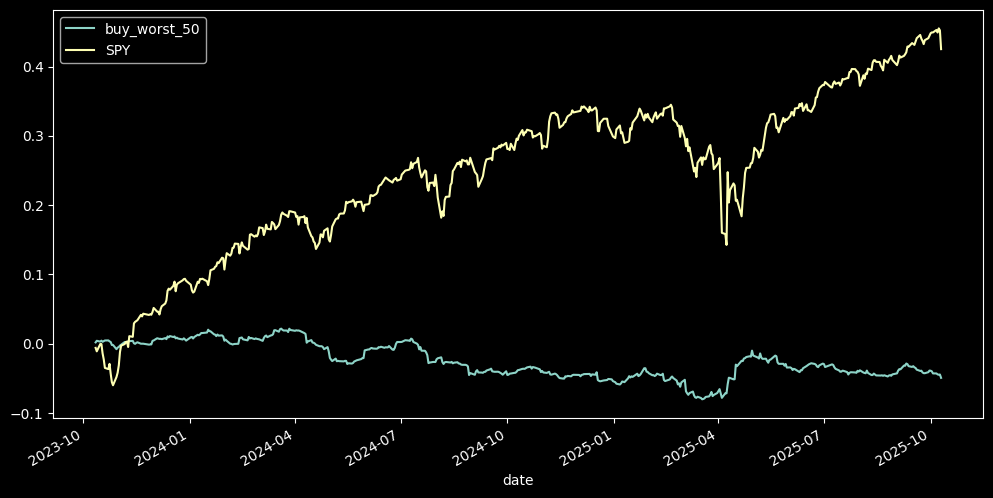
